# CREMA-D Model Explorer

Load, visualize, and compare previously trained CREMA-D experiments using the metrics saved on Google Drive. All plots reuse `src/plot_functions.py` so they stay consistent with other notebooks.

This notebook discovers every experiment run under `MyDrive/CREMAD/Models`, summarizes available metrics/hyperparameters, and lets you select one or more runs to visualize. It is designed for Google Colab and assumes `metrics.json` and `hyperparameters.json` exist inside each run directory.

In [3]:
import os
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount("/content/drive")

# Adjust these paths if your Drive structure differs
BASE_DIR = Path("/content/drive/MyDrive/CREMAD/Models")
# Clone the repository (if necessary) and add `src` to the path
REPO_DIR = Path("/content/qnn-transfer-learning")
import os
if not os.path.isdir(REPO_DIR):
  %cd /content
  !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

SRC_DIR = REPO_DIR / "src"
COMPARISON_DIR = BASE_DIR / "comparisons"

if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))
elif not SRC_DIR.exists():
    print(f"Warning: SRC_DIR not found at {SRC_DIR}. Update the path if needed.")

try:
    from plot_functions import plot_overlapped_metrics
except Exception as exc:  # noqa: BLE001
    raise ImportError(f"Could not import plot_functions.py from {SRC_DIR}. Check the path.") from exc

print(f"BASE_DIR: {BASE_DIR}")
print(f"SRC_DIR: {SRC_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'qnn-transfer-learning'
/content/qnn-transfer-learning
BASE_DIR: /content/drive/MyDrive/CREMAD/Models
SRC_DIR: /content/qnn-transfer-learning/src


## Discover and summarize experiments

In [9]:
# Utility functions to discover runs, load JSON safely, and summarize metadata.
def safe_load_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as handle:
            return json.load(handle)
    except Exception as exc:  # noqa: BLE001
        print(f"Warning: could not read {path} ({exc}). Skipping.")
        return None


def discover_runs(base_dir: Path):
    """Recursively find run folders containing both metrics.json and hyperparameters.json."""
    runs = []
    for root, _dirs, files in os.walk(base_dir):
        files_set = set(files)
        if {"metrics.json", "hyperparams.json"}.issubset(files_set):
            run_path = Path(root)
            rel_parts = run_path.relative_to(base_dir).parts
            model_family = rel_parts[0] if len(rel_parts) >= 1 else "unknown"
            variant = rel_parts[1] if len(rel_parts) >= 2 else "unknown"
            runs.append(
                {
                    "model_family": model_family,
                    "variant": variant,
                    "run_name": run_path.name,
                    "full_path": str(run_path),
                }
            )
    return runs


def load_metrics(run_path: Path):
    return safe_load_json(run_path / "metrics.json") or {}


def load_hparams(run_path: Path):
    return safe_load_json(run_path / "hyperparameters.json") or {}


def _collect_scalar_keys(hparams_list, max_keys: int = 12):
    freq = {}
    for hparams in hparams_list:
        if not isinstance(hparams, dict):
            continue
        for key, val in hparams.items():
            if isinstance(val, (int, float, str, bool)) and len(str(val)) < 100:
                freq[key] = freq.get(key, 0) + 1
    sorted_keys = sorted(freq.items(), key=lambda kv: (-kv[1], kv[0]))
    return [k for k, _ in sorted_keys[:max_keys]]


def build_summary_dataframe(base_dir: Path) -> pd.DataFrame:
    runs = discover_runs(base_dir)
    if not runs:
        print("No runs found. Check BASE_DIR or ensure metrics.json and hyperparameters.json are present.")
        return pd.DataFrame()

    hparams_cache = {run["full_path"]: load_hparams(Path(run["full_path"])) for run in runs}
    scalar_keys = _collect_scalar_keys(list(hparams_cache.values()))

    rows = []
    for run in runs:
        row = run.copy()
        hparams = hparams_cache.get(run["full_path"], {})
        for key in scalar_keys:
            row[key] = hparams.get(key)
        rows.append(row)

    df = pd.DataFrame(rows)
    sort_cols = [col for col in ["model_family", "variant", "run_name"] if col in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    return df


def select_runs(summary_df: pd.DataFrame, indices=None, run_names=None):
    indices = indices or []
    run_names = run_names or []
    mask = pd.Series(False, index=summary_df.index)
    if indices:
        mask |= summary_df.index.isin(indices)
    if run_names:
        mask |= summary_df["run_name"].isin(run_names)
    return summary_df[mask].to_dict(orient="records")


def get_metric_series(metrics: dict, keys):
    for key in keys:
        if key in metrics:
            return metrics[key]
    return None


def plot_training_for_run(run: dict):
    run_path = Path(run["full_path"])
    metrics_path = run_path / "metrics.json"
    save_path = run_path / "training_overview.png"
    print(f"\nPlotting {run['model_family']} / {run['variant']} / {run['run_name']}")
    try:
        plot_overlapped_metrics(str(metrics_path), save_path=str(save_path))
    except Exception as exc:  # noqa: BLE001
        print(f"Warning: failed to plot {metrics_path}: {exc}")


def plot_comparison_across_runs(selected_runs):
    if not selected_runs:
        print("No runs selected for comparison.")
        return

    COMPARISON_DIR.mkdir(parents=True, exist_ok=True)
    runs_data = []
    for run in selected_runs:
        metrics = load_metrics(Path(run["full_path"]))
        runs_data.append((run, metrics))

    # Line plot of validation/test accuracy across runs
    fig, ax = plt.subplots(figsize=(10, 6))
    for run, metrics in runs_data:
        accs = get_metric_series(metrics, ["val_accs", "test_accs", "validation_accs"])
        if not accs:
            continue
        epochs = range(1, len(accs) + 1)
        label = f"{run['model_family']} | {run['variant']} | {run['run_name']}"
        ax.plot(epochs, accs, linewidth=2, label=label)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation/Test Accuracy")
    ax.set_title("Accuracy over epochs for selected runs")
    ax.set_ylim(0, 1)
    ax.legend(fontsize=9, frameon=False)
    ax.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout()
    line_path = COMPARISON_DIR / "accuracy_over_epochs.png"
    plt.savefig(line_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {line_path}")
    plt.show()

    # Bar plot of best validation/test accuracy per run
    labels, best_accs = [], []
    for run, metrics in runs_data:
        accs = get_metric_series(metrics, ["val_accs", "test_accs", "validation_accs"])
        if accs:
            labels.append(f"{run['model_family']}\n{run['variant']}\n{run['run_name']}")
            best_accs.append(max(accs))
    if best_accs:
        fig, ax = plt.subplots(figsize=(max(8, 1.5 * len(best_accs)), 5))
        bars = ax.bar(labels, best_accs, color="tab:blue", alpha=0.8)
        ax.set_ylabel("Best Validation/Test Accuracy")
        ax.set_title("Best accuracy per run")
        ax.set_ylim(0, 1)
        ax.grid(True, axis="y", alpha=0.3, linestyle="--")
        plt.setp(ax.get_xticklabels(), rotation=20, ha="right")
        for bar, acc in zip(bars, best_accs):
            ax.text(bar.get_x() + bar.get_width() / 2, acc + 0.01, f"{acc:.3f}", ha="center", va="bottom")
        plt.tight_layout()
        bar_path = COMPARISON_DIR / "best_accuracy_barplot.png"
        plt.savefig(bar_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {bar_path}")
        plt.show()
    else:
        print("No accuracy metrics found for the selected runs.")

In [10]:
summary_df = build_summary_dataframe(BASE_DIR)
summary_df

,model_family,variant,run_name,full_path
0,custom_cnn,custom_cnn_classic,run_11-19_21-20-11,/content/drive/MyDrive/CREMAD/Models/custom_cn...
1,custom_cnn,custom_cnn_classic,run_11-19_22-10-47,/content/drive/MyDrive/CREMAD/Models/custom_cn...
2,custom_cnn,custom_cnn_quantum,run_11-19_21-35-58,/content/drive/MyDrive/CREMAD/Models/custom_cn...
3,custom_cnn,custom_cnn_quantum,run_11-19_21-48-24,/content/drive/MyDrive/CREMAD/Models/custom_cn...
4,emb_panns_cnn14,emb_panns_cnn14_classic,run_11-21_17-31-45,/content/drive/MyDrive/CREMAD/Models/emb_panns...
5,emb_panns_cnn14,emb_panns_cnn14_classic,run_11-21_17-41-06,/content/drive/MyDrive/CREMAD/Models/emb_panns...
6,emb_panns_cnn14,emb_panns_cnn14_quantum,run_11-21_17-02-59,/content/drive/MyDrive/CREMAD/Models/emb_panns...
7,emb_panns_cnn14,emb_panns_cnn14_quantum,run_11-29_00-52-58,/content/drive/MyDrive/CREMAD/Models/emb_panns...
8,emb_resnet18,emb_resnet18_classic,run_11-15_21-05-36,/content/drive/MyDrive/CREMAD/Models/emb_resne...
9,emb_resnet18,emb_resnet18_classic,run_11-17_17-39-36,/content/drive/MyDrive/CREMAD/Models/emb_resne...


## Select models to analyze

Pick runs by index (from the summary table) or by `run_name`. Update `SELECTED_RUN_INDICES` or `SELECTED_RUN_NAMES` as needed.

In [11]:
SELECTED_RUN_INDICES = [7]  # e.g., [0, 2]
SELECTED_RUN_NAMES = []  # e.g., ["2023-11-01_12-00-00"]

selected_runs = select_runs(summary_df, indices=SELECTED_RUN_INDICES, run_names=SELECTED_RUN_NAMES)
print(f"Selected {len(selected_runs)} run(s).")
selected_runs

Selected 1 run(s).


[{'model_family': 'emb_panns_cnn14',
  'variant': 'emb_panns_cnn14_quantum',
  'run_name': 'run_11-29_00-52-58',
  'full_path': '/content/drive/MyDrive/CREMAD/Models/emb_panns_cnn14/emb_panns_cnn14_quantum/run_11-29_00-52-58'}]

## Plot training evolution for each model

Plots use `plot_overlapped_metrics` from `plot_functions.py` and are also saved inside each run folder as `training_overview.png`.


Plotting emb_panns_cnn14 / emb_panns_cnn14_quantum / run_11-29_00-52-58
Figure saved to: /content/drive/MyDrive/CREMAD/Models/emb_panns_cnn14/emb_panns_cnn14_quantum/run_11-29_00-52-58/training_overview.png


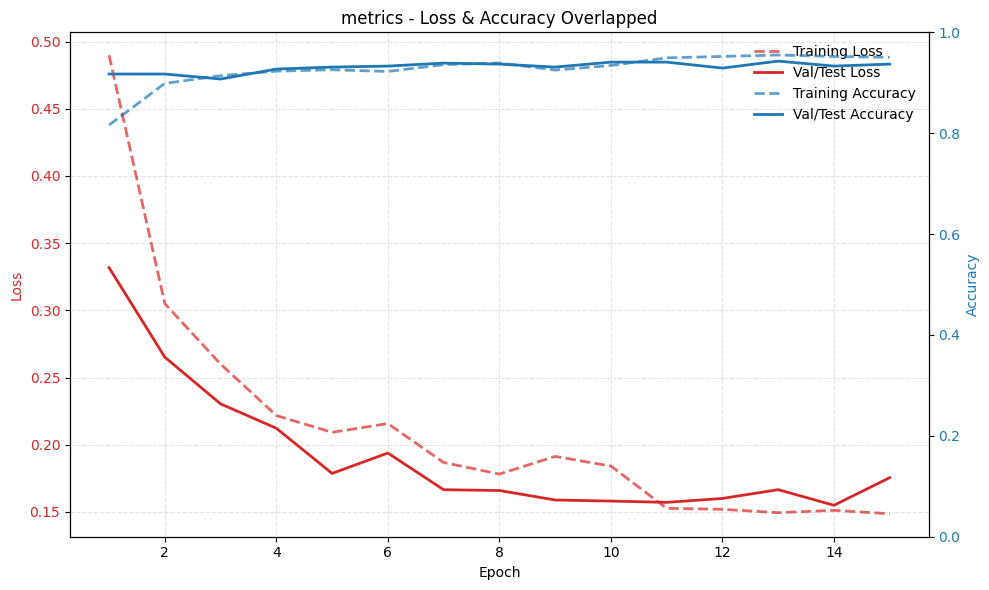


Model statistics for metrics:
  Best Validation/Test Loss: 0.1550
  Best Validation/Test Accuracy: 0.9429
  Epochs trained: 15


In [12]:
for run in selected_runs:
    plot_training_for_run(run)

## Cross-model comparison

Generates comparison plots (line + bar) for the selected runs and stores them under `BASE_DIR / "comparisons"`.

Saved: /content/drive/MyDrive/CREMAD/Models/comparisons/accuracy_over_epochs.png


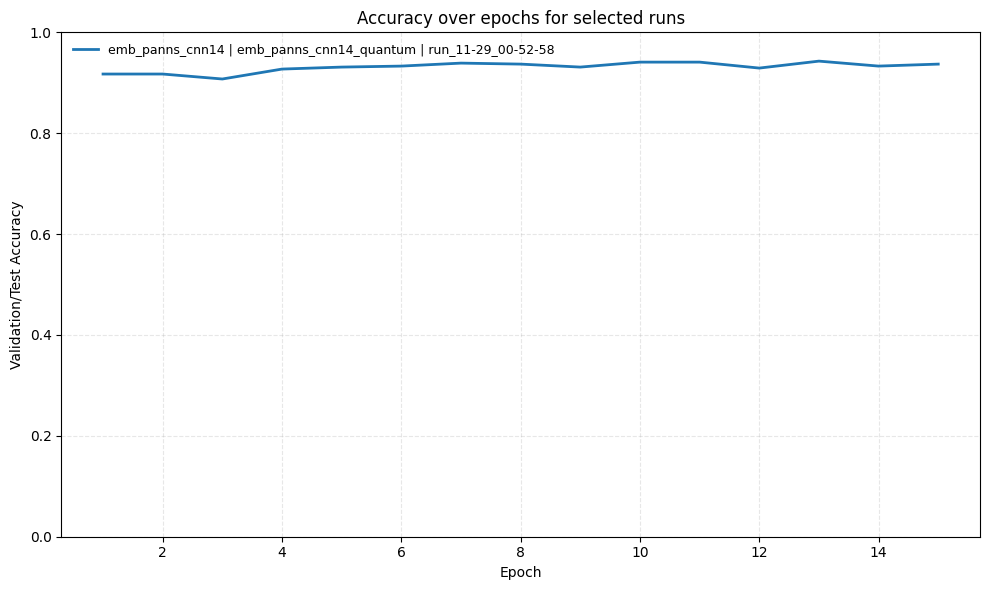

Saved: /content/drive/MyDrive/CREMAD/Models/comparisons/best_accuracy_barplot.png


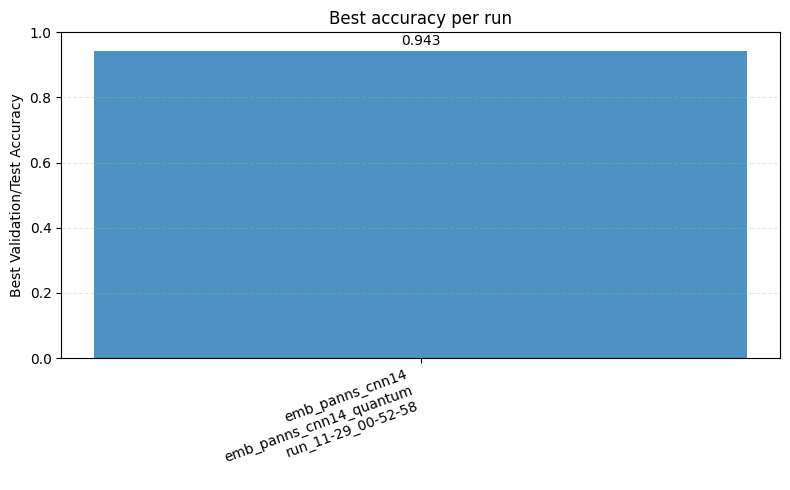

In [13]:
plot_comparison_across_runs(selected_runs)